# Import all kind of stuff

In [1]:
import sys

import numpy as np
from numpy.typing import NDArray

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

from scipy.special import jv

local = "/Users/oliver/Documents/doctoral-thesis/.utilities/"
remote = "/Users/oliver/Documents/p5control-bluefors-evaluation/"
textwidth = 4.25279  # in
textheight = 6.85173 # in

sys.path.append(local)
sys.path.append(remote)

plt.style.use(f'{local}thesisstyle.mplstyle')

from thesislayout import get_figure, theory_layout

from cpd5 import get_color, get_colors
from cpd5 import (
    seeblau120,
    seeblau100,
    seeblau80,
    seeblau65,
    seeblau35,
    seeblau20,
)
seeblau = [seeblau120, seeblau100, seeblau65, seeblau35, seeblau20]
from cpd5 import (
    seegrau120,
    seegrau100,
    seegrau80,
    seegrau65,
    seegrau35,
    seegrau20,
)
seegrau = [seegrau120, seegrau100, seegrau65, seegrau35, seegrau20]

from theory.utilities.constants import k_B_meV, G_0_muS, e, h
from theory.utilities.types import NDArray64

from theory.utilities.functions import bin_y_over_x, oversample

# theory
from theory.models.bcs import Delta_meV_of_T
from theory.models.bcs import N_of_E, f_of_E
from theory.models.bcs import get_I_nA as get_I_nA_bcs
from theory.models.tg import get_I_pat_nA as get_I_nA_tg

from matplotlib_inline.backend_inline import InlineBackend
InlineBackend.print_figure_kwargs = {"bbox_inches": None, "pad_inches": 0.0}
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None, 'pad_inches': 0.0}
%config InlineBackend.figure_format = "retina"   # or "png"
%config InlineBackend.rc = {"figure.dpi": 300}   # choose a value you like

%matplotlib inline

# gap-suppression

In [2]:
def Delta_of_T(T: NDArray[np.float64], T_C: float = 1.0, Delta_0: float = 1.0):
    Delta = np.where(T != 0, Delta_0 * np.tanh(1.74 * np.sqrt(T_C / T - 1)), 1.0)
    return Delta


T = np.linspace(0, 1, 101)

Delta = Delta_of_T(T)

/var/folders/kc/8fnzl3f94vxgl8w4wm3wfvk80000gn/T/ipykernel_56853/816220097.py:2: RuntimeWarning: divide by zero encountered in divide
  Delta = np.where(T != 0, Delta_0 * np.tanh(1.74 * np.sqrt(T_C / T - 1)), 1.0)


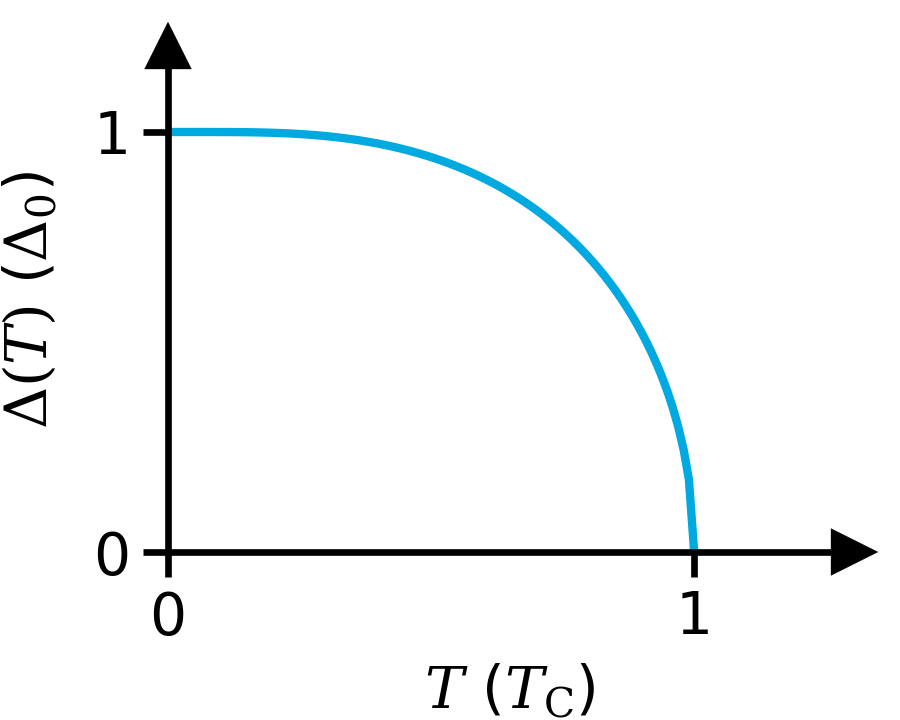

In [3]:
fig, ax = get_figure(figsize=(1.5, 1.2), subfigure=True)

ax.plot(T, Delta, color=seeblau100)

ax.set_xlim(0, 1.3)
ax.set_xticks([0, 1])
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 1])

xlabel = "$T$ ($T_\\mathrm{C}$)"
ylabel = "$\\Delta(T)$ ($\\Delta_0$)"
title = "gap"

theory_layout(fig, ax, title, xlabel, ylabel)

# dos-fermi

In [4]:
Delta_meV = 0.180
E_meV = np.linspace(-2.5 * Delta_meV, 2.5 * Delta_meV, 1001)
gammas_Delta = np.array([0, 1, 2.5, 5]) * 1e-2

Ns = np.full((gammas_Delta.shape[0], E_meV.shape[0]), np.nan)
for i, gamma in enumerate(gammas_Delta):
    Ns[i, :] = N_of_E(
        E_meV=E_meV,
        Delta_meV=Delta_meV,
        gamma_meV=gamma * Delta_meV,
    )

/Users/oliver/Documents/p5control-bluefors-evaluation/theory/models/bcs.py:55: RuntimeWarning: divide by zero encountered in divide
  dos = np.divide(E_complex_meV, denom)
/Users/oliver/Documents/p5control-bluefors-evaluation/theory/models/bcs.py:55: RuntimeWarning: invalid value encountered in divide
  dos = np.divide(E_complex_meV, denom)


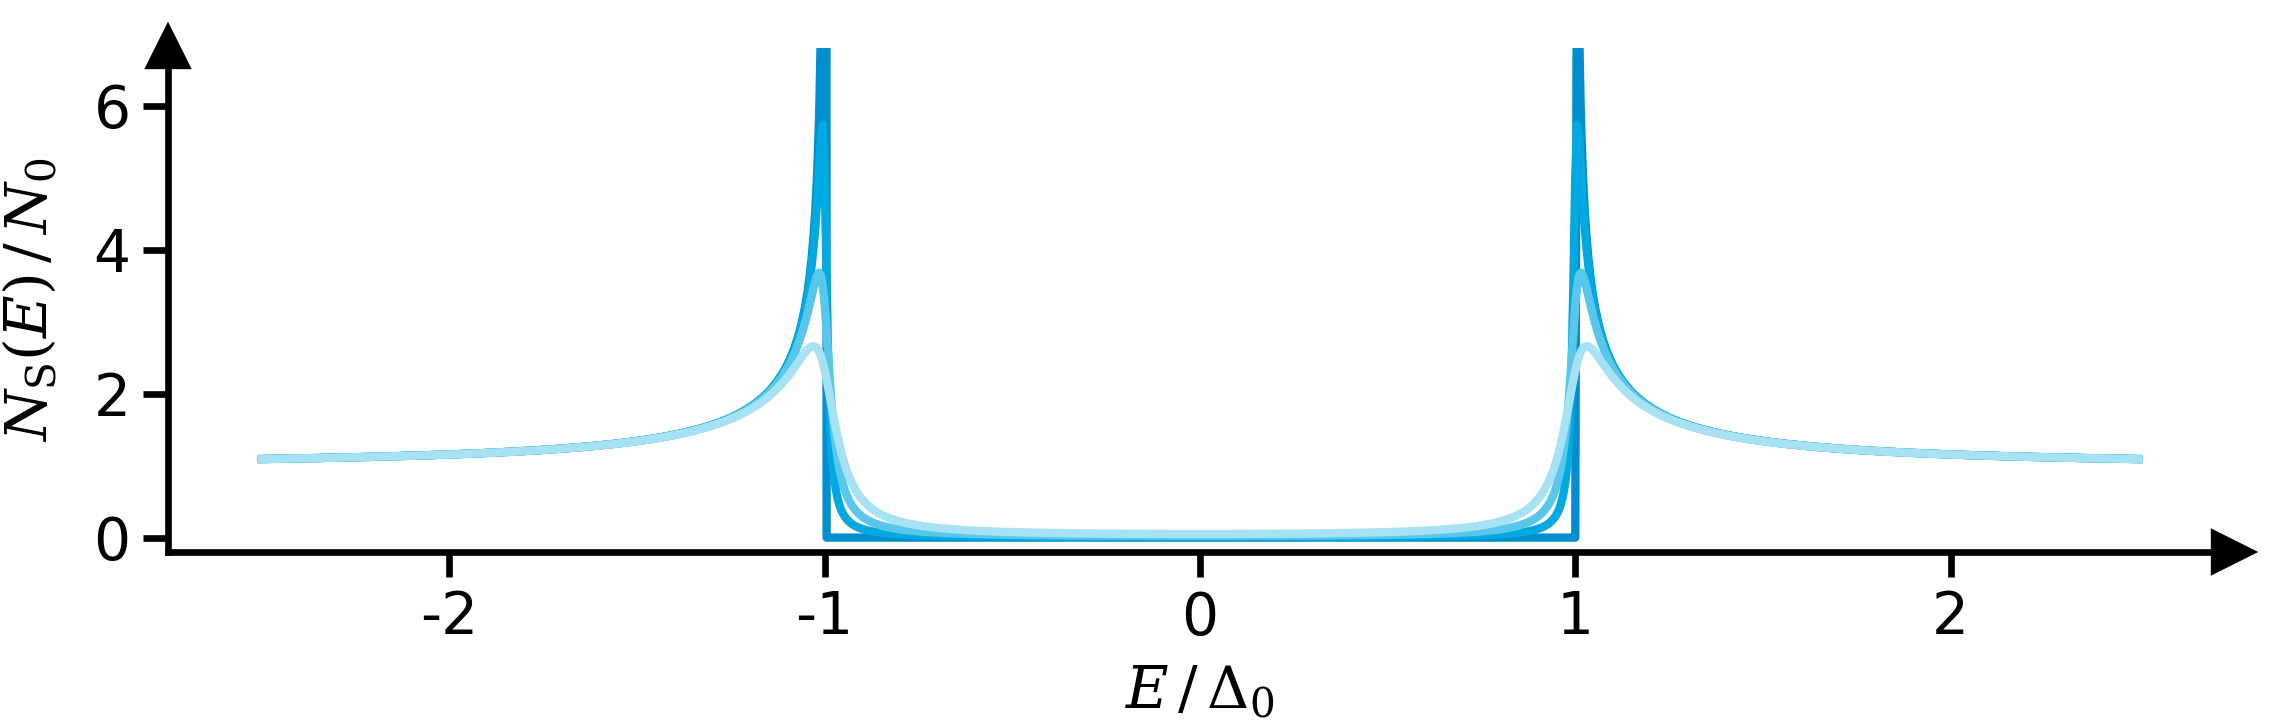

In [5]:
fig, ax = get_figure(figsize=(3.8, 1.2), subfigure=True)

for i, Gamma in enumerate(gammas_Delta):
    ax.plot(
        E_meV / Delta_meV,
        Ns[i, :],
        color=seeblau[i],
        zorder=i,
        label=f"{Gamma*1e2}e-2",
    )

ax.set_ylim(-0.2, 6.8)
ax.set_yticks([0, 2, 4, 6])
ax.set_xticks([-2, -1, 0, 1, 2])

xlabel = "$E\\,/\\,\\Delta_0$"
ylabel = "$N_\\mathrm{S}(E)\\,/\\,N_0$"
title = "dos"

theory_layout(fig, ax, title, xlabel, ylabel)

In [6]:
Delta_meV = 0.180
E_meV = np.linspace(-1.5 * Delta_meV, 1.5 * Delta_meV, 1501)
Ts_TC = np.array([0, 0.3, 0.6, 0.9])
T_C = Delta_meV / (1.764 * k_B_meV)

fs = np.full((Ts_TC.shape[0], E_meV.shape[0]), np.nan)
for i, T in enumerate(Ts_TC):
    fs[i, :] = f_of_E(E_meV=E_meV, T_K=T * T_C)

dfs = -np.gradient(fs, E_meV / Delta_meV, axis=1)
dfs[0, :] = np.zeros_like(E_meV)
dfs[0, 750] = 10

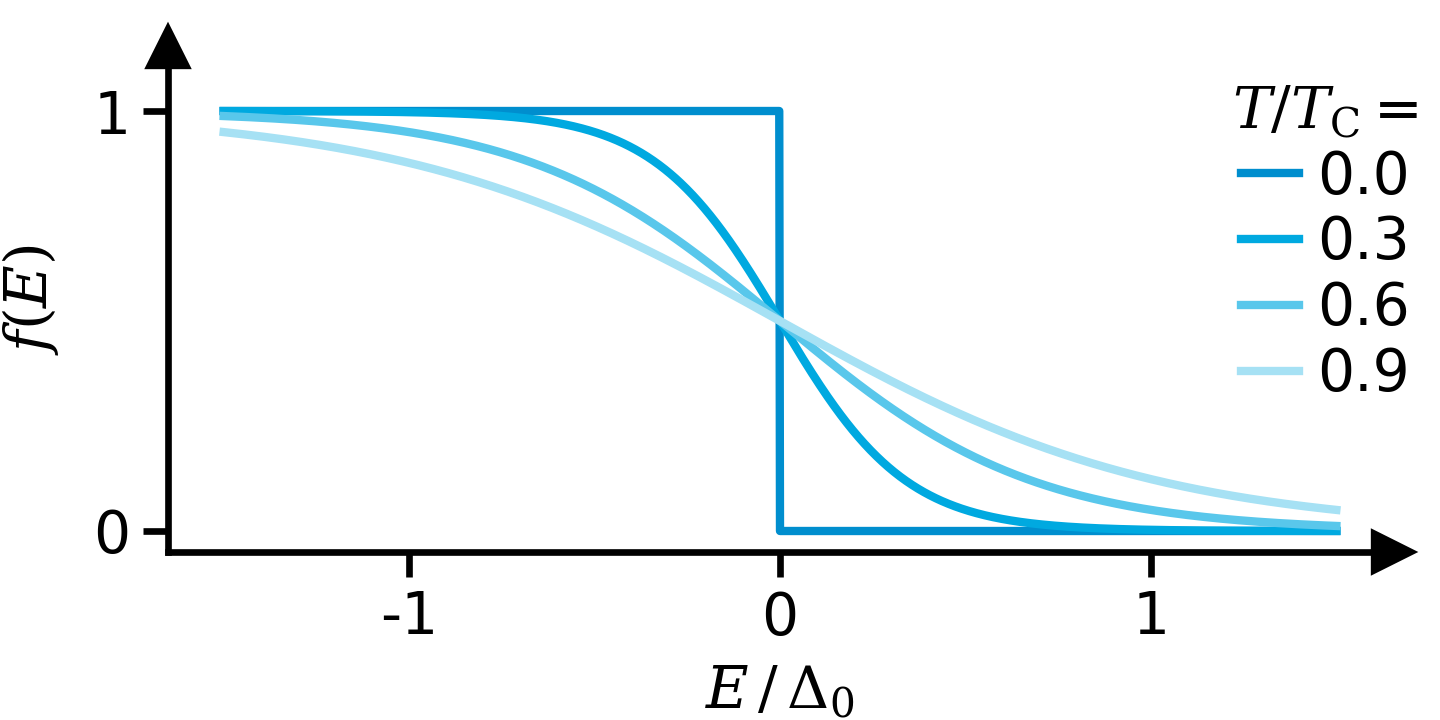

In [7]:
fig, ax = get_figure(figsize=(2.4, 1.2), subfigure=True)

for i, T in enumerate(Ts_TC):
    ax.plot(
        E_meV / Delta_meV,
        fs[i, :],
        zorder=i,
        color=seeblau[i],
        label=f"{T:1.1f}",
    )

ax.legend(
    title=r"$T/T_\mathrm{C} = $",
    handlelength=1.0,
    loc="upper right",
    frameon=False,
    fontsize=7,
    title_fontsize=7,
    bbox_to_anchor=(1.05, 1.0),
    # bbox_to_anchor=(1.0, 1.15),
    borderpad=0.1,  # reduces padding inside the legend box
    labelspacing=0.15,  # reduces vertical spacing between items
    handletextpad=0.3,  # reduces spacing between line and label
)


ax.set_ylim(-0.05, 1.15)
ax.set_yticks([0, 1])
ax.set_xticks([-1, 0, 1])

xlabel = "$E\\,/\\,\\Delta_0$"
ylabel = "$f(E)$"
title = "fermi"

theory_layout(fig, ax, title, xlabel, ylabel)

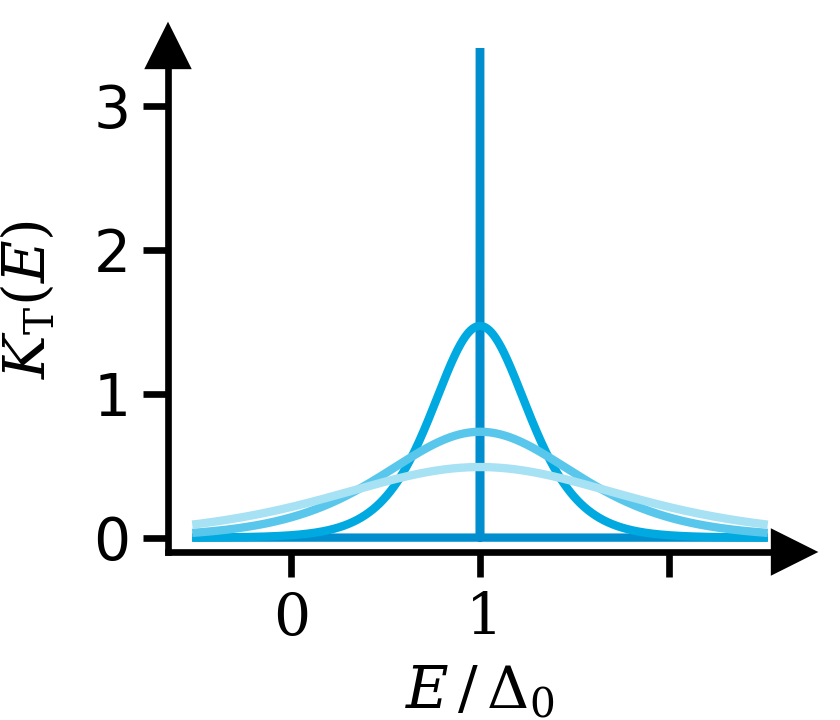

In [8]:
fig, ax = get_figure(figsize=(1.4, 1.2), subfigure=True)

for i, T in enumerate(Ts_TC):
    ax.plot(
        E_meV / Delta_meV,
        dfs[i, :],
        color=seeblau[i],
        zorder=i - 10,
        label=f"{T:1.1f}",
    )

ax.set_ylim(-0.1, 3.4)
ax.set_yticks([0, 1, 2, 3])
ax.set_xticks([-1, 0, 1], labels=["$0$", "$1$", " "])

xlabel = "$E\\,/\\,\\Delta_0$"
ylabel = "$K_\\mathrm{T}(E)$"
title = "fermi-kernel"

theory_layout(fig, ax, title, xlabel, ylabel)

# tunnel-current

Attention: don't use $G_0$ yet. its not introduced. stick to $G_N$

In [9]:
# generate data
Delta_meV = 0.189
V_mV = np.linspace(0, 2.5 * Delta_meV, 601)  # mV
G_N = 1
T_TC_NS = np.array([0, 0.1, 0.2, 0.4])
# T_TC_SS = np.array([0, 0.1, 0.2, 0.4])
T_TC_SS = np.array([0, 0.4, 0.5, 0.6])
T_C_K = 1.2
gamma_Delta = np.array([0, 1, 2.5, 5.0]) * 1e-2
gamma_Delta = np.array([0, 2.5, 5, 7.5]) * 1e-2

I_NN = G_N * G_0_muS * V_mV  # nA
dIdV_NN = np.gradient(I_NN, V_mV) / G_0_muS

I_NS_T = np.full((T_TC_NS.shape[0], V_mV.shape[0]), np.nan)
I_SS_T = np.full((T_TC_SS.shape[0], V_mV.shape[0]), np.nan)
I_NS_Gamma = np.full((gamma_Delta.shape[0], V_mV.shape[0]), np.nan)
I_SS_Gamma = np.full((gamma_Delta.shape[0], V_mV.shape[0]), np.nan)

for i, T in enumerate(T_TC_NS):
    I_NS_T[i, :] = get_I_nA_bcs(
        V_mV=V_mV,
        G_N=G_N,
        Delta_meV=(0.0, Delta_meV),
        T_K=T * T_C_K,
        gamma_meV=0.0,
    )
for i, T in enumerate(T_TC_SS):
    I_SS_T[i, :] = get_I_nA_bcs(
        V_mV=V_mV,
        G_N=G_N,
        Delta_meV=(Delta_meV, Delta_meV),
        T_K=T * T_C_K,
        gamma_meV=0.0,
    )

for i, gamma in enumerate(gamma_Delta):
    I_NS_Gamma[i, :] = get_I_nA_bcs(
        V_mV=V_mV,
        G_N=G_N,
        Delta_meV=(0.0, Delta_meV),
        T_K=0.0,
        gamma_meV=gamma * Delta_meV,
    )
    I_SS_Gamma[i, :] = get_I_nA_bcs(
        V_mV=V_mV,
        G_N=G_N,
        Delta_meV=(Delta_meV, Delta_meV),
        T_K=0.0,
        gamma_meV=gamma * Delta_meV,
    )

dIdV_NS_T = np.gradient(I_NS_T, V_mV, axis=1) / G_0_muS
dIdV_SS_T = np.gradient(I_SS_T, V_mV, axis=1) / G_0_muS
dIdV_NS_Gamma = np.gradient(I_NS_Gamma, V_mV, axis=1) / G_0_muS
dIdV_SS_Gamma = np.gradient(I_SS_Gamma, V_mV, axis=1) / G_0_muS

I_NS_T /= Delta_meV * G_0_muS
I_SS_T /= Delta_meV * G_0_muS
I_NS_Gamma /= Delta_meV * G_0_muS
I_SS_Gamma /= Delta_meV * G_0_muS

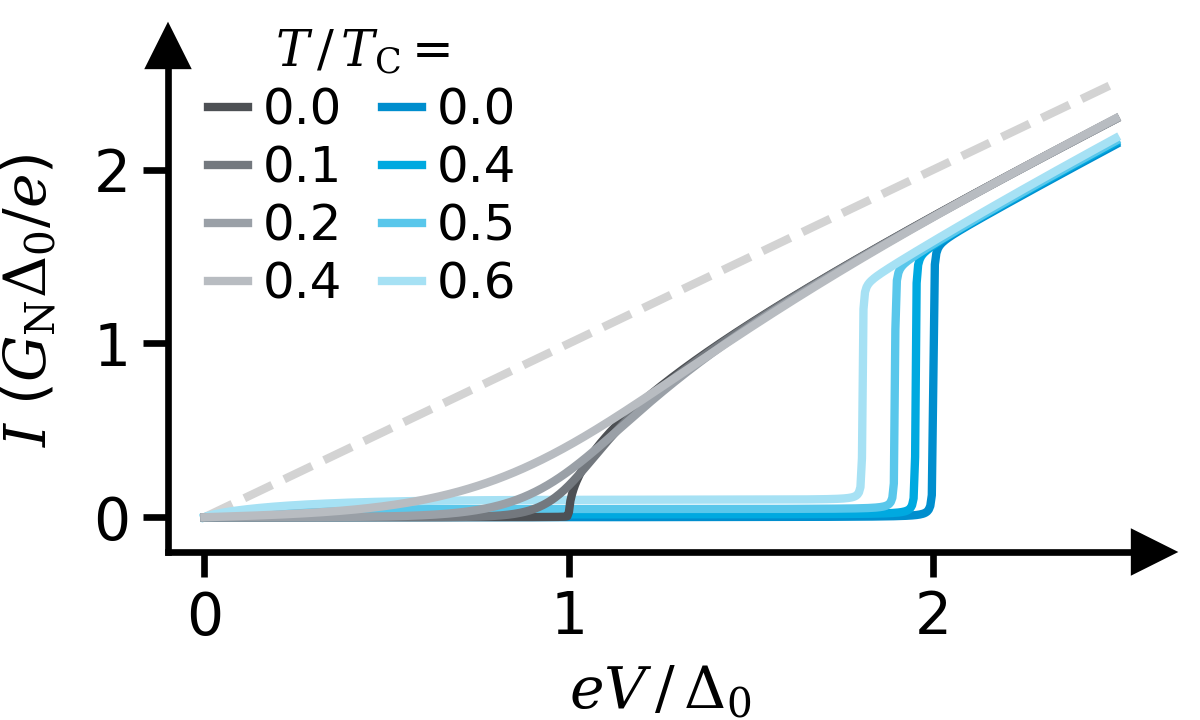

In [10]:
fig, ax = get_figure(figsize=(2.0, 1.2), subfigure=True)

ax.plot(
    V_mV / Delta_meV,
    V_mV / Delta_meV,
    linestyle="--",
    color="lightgrey",
    zorder=0,
)

for i, T in enumerate(T_TC_NS):
    # NS
    ax.plot(
        V_mV / Delta_meV,
        I_NS_T[i, :],
        color=seegrau[i],
        zorder=i + 10,
        label=f"{T:1.1f}",
    )

for i, T in enumerate(T_TC_SS):
    # SS
    ax.plot(
        V_mV / Delta_meV,
        I_SS_T[i, :],
        color=seeblau[i],
        zorder=i,
        label=f"{T:1.1f}",
    )

ax.legend(
    title="$T\\,/\\,T_\\mathrm{C} = $",
    handlelength=0.8,
    loc="upper left",
    frameon=False,
    fontsize=6,
    title_fontsize=6,
    ncols=2,
    columnspacing=0.8,
    borderpad=0.1,  # reduces padding inside the legend box
    labelspacing=0.2,  # reduces vertical spacing between items
    handletextpad=0.3,  # reduces spacing between line and label
    bbox_to_anchor=(0.01, 1.1),
)

ax.set_xlim(-0.1, 2.6)
ax.set_ylim(-0.2, 2.7)
ax.set_yticks([0, 1, 2])
ax.set_xticks([0, 1, 2])

xlabel = "$eV\\,/\\,\\Delta_0$"
ylabel = "$I$ ($G_\\mathrm{N}\\Delta_0 /e$)"
title = "tunnel-iv-T"

theory_layout(fig, ax, title, xlabel, ylabel)

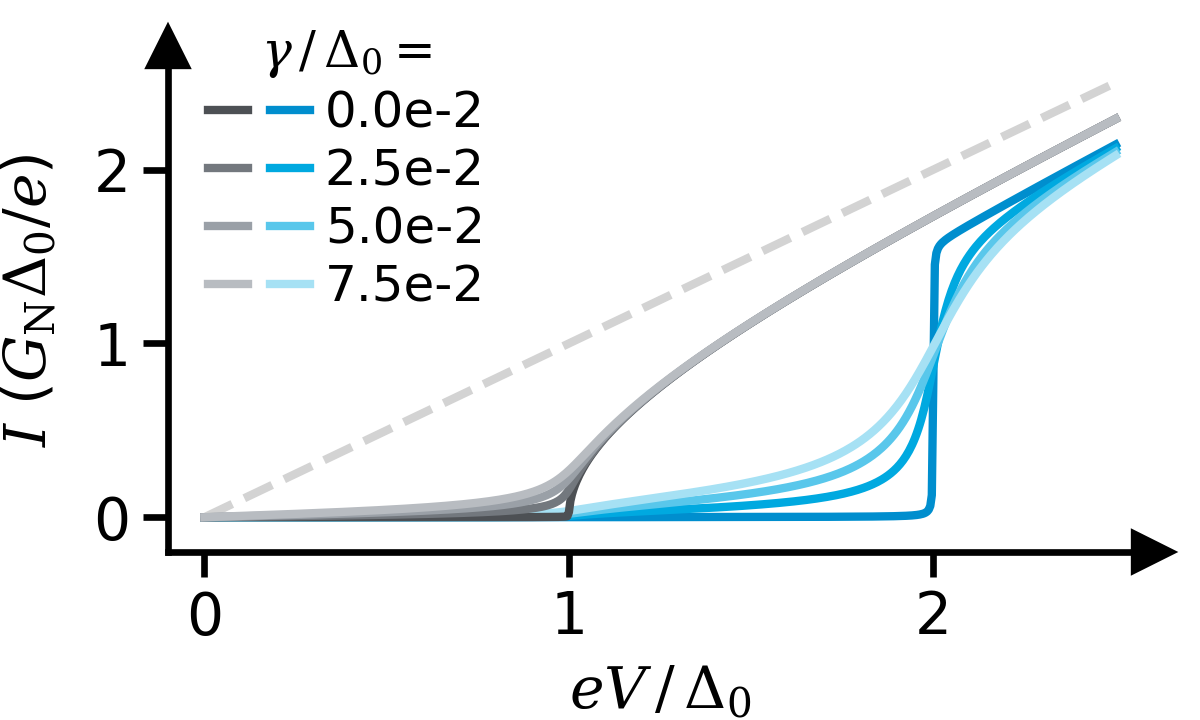

In [11]:
fig, ax = get_figure(figsize=(2.0, 1.2), subfigure=True)

ax.plot(
    V_mV / Delta_meV,
    V_mV / Delta_meV,
    linestyle="--",
    color="lightgrey",
    zorder=0,
)

for i, gamma in enumerate(gamma_Delta):
    # NS
    ax.plot(
        V_mV / Delta_meV,
        I_NS_Gamma[i, :],
        color=seegrau[i],
        zorder=i + 10,
        label="$\\,$",
    )

for i, gamma in enumerate(gamma_Delta):
    # SS
    ax.plot(
        V_mV / Delta_meV,
        I_SS_Gamma[i, :],
        color=seeblau[i],
        zorder=i,
        label=f"{gamma*1e2:.1f}e-2",
    )

ax.set_xlim(-0.1, 2.6)
ax.set_ylim(-0.2, 2.7)
ax.set_yticks([0, 1, 2])
ax.set_xticks([0, 1, 2])

ax.legend(
    title="$\\gamma\\,/\\,\\Delta_0 = $",
    handlelength=0.8,
    loc="upper left",
    frameon=False,
    fontsize=6,
    title_fontsize=6,
    ncols=2,
    columnspacing=0.1,
    borderpad=0.1,  # reduces padding inside the legend box
    labelspacing=0.2,  # reduces vertical spacing between items
    handletextpad=0.3,  # reduces spacing between line and label
    bbox_to_anchor=(0.01, 1.1),
)

xlabel = "$eV\\,/\\,\\Delta_0$"
ylabel = "$I$ ($G_\\mathrm{N}\\Delta_0 /e$)"
title = "tunnel-iv-gamma"

theory_layout(fig, ax, title, xlabel, ylabel)

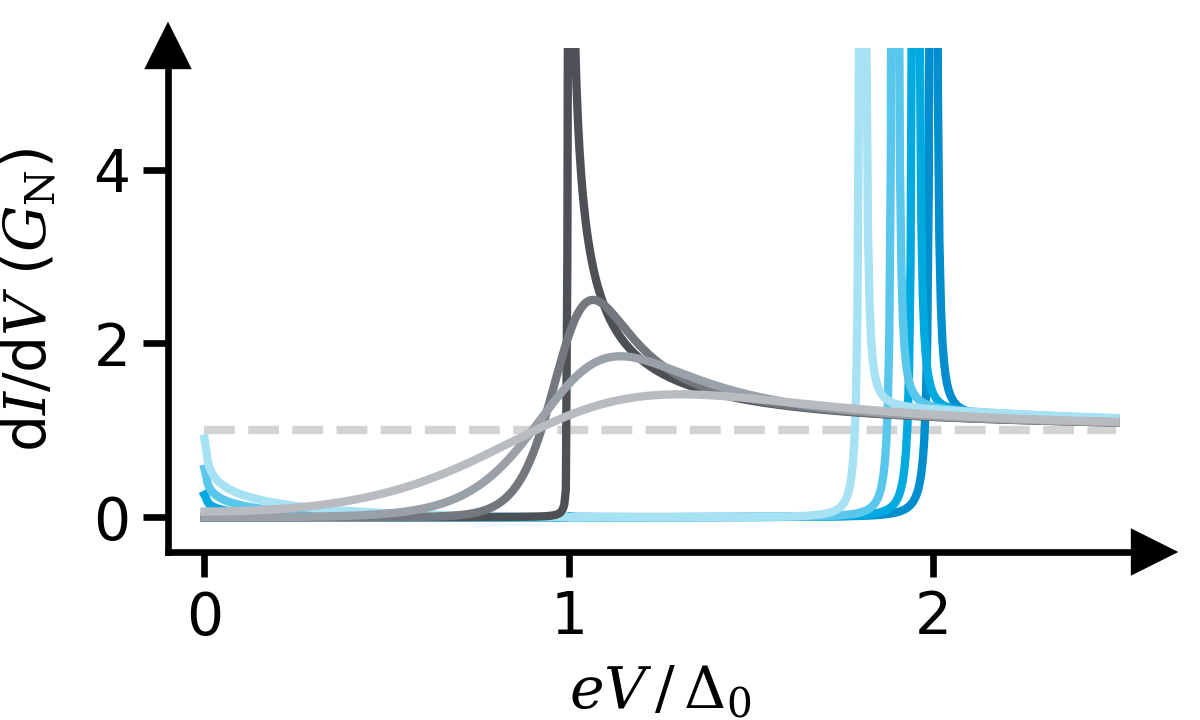

In [12]:
fig, ax = get_figure(figsize=(2.0, 1.2), subfigure=True)

ax.plot(
    V_mV / Delta_meV,
    np.ones_like(V_mV / Delta_meV),
    linestyle="--",
    color="lightgrey",
    zorder=0,
)

for i, T in enumerate(T_TC_NS):
    # NS
    ax.plot(
        V_mV / Delta_meV,
        dIdV_NS_T[i, :],
        color=seegrau[i],
        zorder=i + 100,
        label=f"{T:1.1f}",
    )

for i, T in enumerate(T_TC_SS):
    # SS
    ax.plot(
        V_mV / Delta_meV,
        dIdV_SS_T[i, :],
        color=seeblau[i],
        zorder=i + 10,
        label=f"{T:1.1f}",
    )

ax.set_xlim(-0.1, 2.6)
ax.set_xticks([0, 1, 2])
ax.set_ylim(-0.4, 5.4)
ax.set_yticks([0, 2, 4])

xlabel = "$eV\\,/\\,\\Delta_0$"
ylabel = "d$I/$d$V$ ($G_\\mathrm{N}$)"
title = "tunnel-didv-T"

theory_layout(fig, ax, title, xlabel, ylabel)

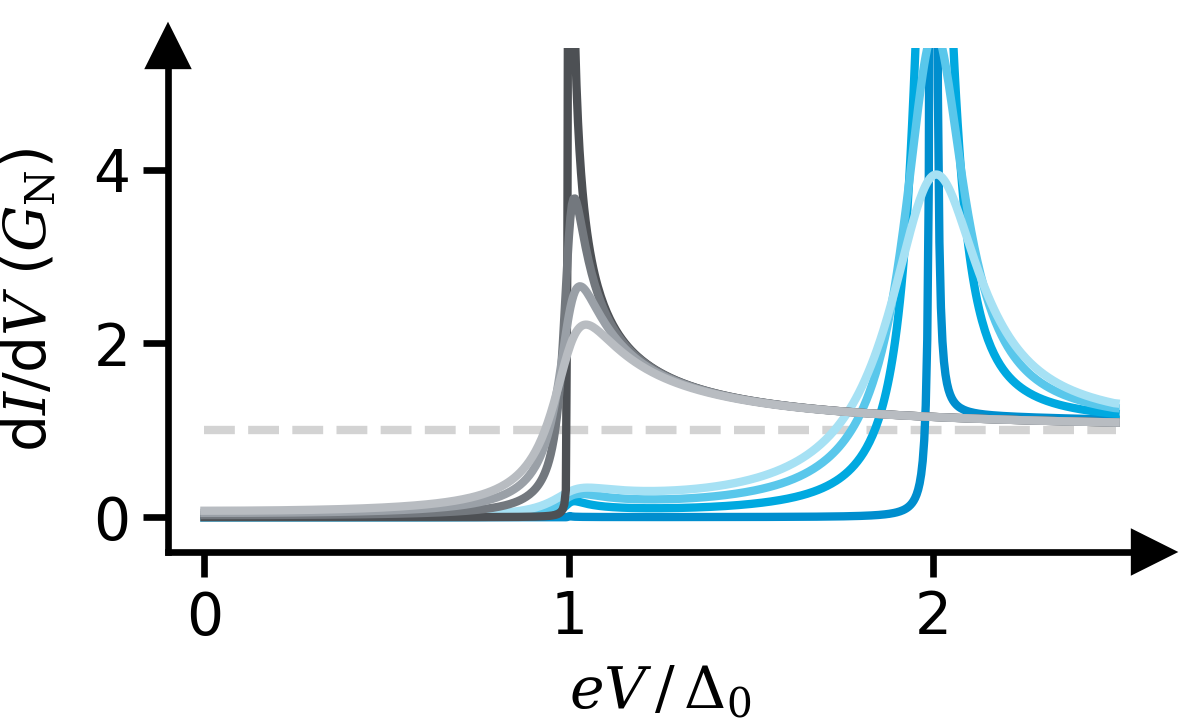

In [13]:
fig, ax = get_figure(figsize=(2.0, 1.2), subfigure=True)

ax.plot(
    V_mV / Delta_meV,
    np.ones_like(V_mV / Delta_meV),
    linestyle="--",
    color="lightgrey",
    zorder=0,
)

for i, gamma in enumerate(gamma_Delta):
    # NS
    ax.plot(
        V_mV / Delta_meV,
        dIdV_NS_Gamma[i, :],
        color=seegrau[i],
        zorder=i + 10,
        label="$\\,$",
    )

for i, gamma in enumerate(gamma_Delta):
    # SS
    ax.plot(
        V_mV / Delta_meV,
        dIdV_SS_Gamma[i, :],
        color=seeblau[i],
        zorder=i,
    )

ax.set_xlim(-0.1, 2.6)
ax.set_xticks([0, 1, 2])
ax.set_ylim(-0.4, 5.4)
ax.set_yticks([0, 2, 4])

xlabel = "$eV\\,/\\,\\Delta_0$"
ylabel = "d$I/$d$V$ ($G_\\mathrm{N}$)"
title = "tunnel-didv-gamma"

theory_layout(fig, ax, title, xlabel, ylabel)

# PAT

In [18]:
# generate data
Delta_meV = 0.180
V_mV = np.linspace(0, 2.5, 601) * Delta_meV  # mV
A_mV = np.array([0, 0.1, 0.2]) * Delta_meV  # mV
A_mV = np.array([0, 0.3, 0.6]) * Delta_meV  # mV

G_N = 1
T_K = 0.0
gamma_meV = 0.0
nu_GHz = 10.0

N_S = np.full((A_mV.shape[0], V_mV.shape[0]), np.nan)
I_NS = np.full((A_mV.shape[0], V_mV.shape[0]), np.nan)
I_SS = np.full((A_mV.shape[0], V_mV.shape[0]), np.nan)

N_S_0 = N_of_E(E_meV=V_mV, Delta_meV=Delta_meV, gamma_meV=gamma_meV)

I_NS_0 = get_I_nA_bcs(
    V_mV=V_mV,
    G_N=G_N,
    Delta_meV=(0.0, Delta_meV),
    T_K=T_K,
    gamma_meV=gamma_meV,
)
I_SS_0 = get_I_nA_bcs(
    V_mV=V_mV,
    G_N=G_N,
    Delta_meV=(Delta_meV, Delta_meV),
    T_K=T_K,
    gamma_meV=gamma_meV,
)

N_S = get_I_nA_tg(A_mV=A_mV, V_mV=V_mV, I_nA=N_S_0, nu_GHz=nu_GHz)
I_NS = get_I_nA_tg(A_mV=A_mV, V_mV=V_mV, I_nA=I_NS_0, nu_GHz=nu_GHz)
I_SS = get_I_nA_tg(A_mV=A_mV, V_mV=V_mV, I_nA=I_SS_0, nu_GHz=nu_GHz)

dIdV_NS = np.gradient(I_NS, V_mV, axis=1) / G_0_muS
dIdV_SS = np.gradient(I_SS, V_mV, axis=1) / G_0_muS

I_NS /= Delta_meV * G_0_muS
I_SS /= Delta_meV * G_0_muS

/Users/oliver/Documents/p5control-bluefors-evaluation/theory/models/bcs.py:55: RuntimeWarning: divide by zero encountered in divide
  dos = np.divide(E_complex_meV, denom)
/Users/oliver/Documents/p5control-bluefors-evaluation/theory/models/bcs.py:55: RuntimeWarning: invalid value encountered in divide
  dos = np.divide(E_complex_meV, denom)


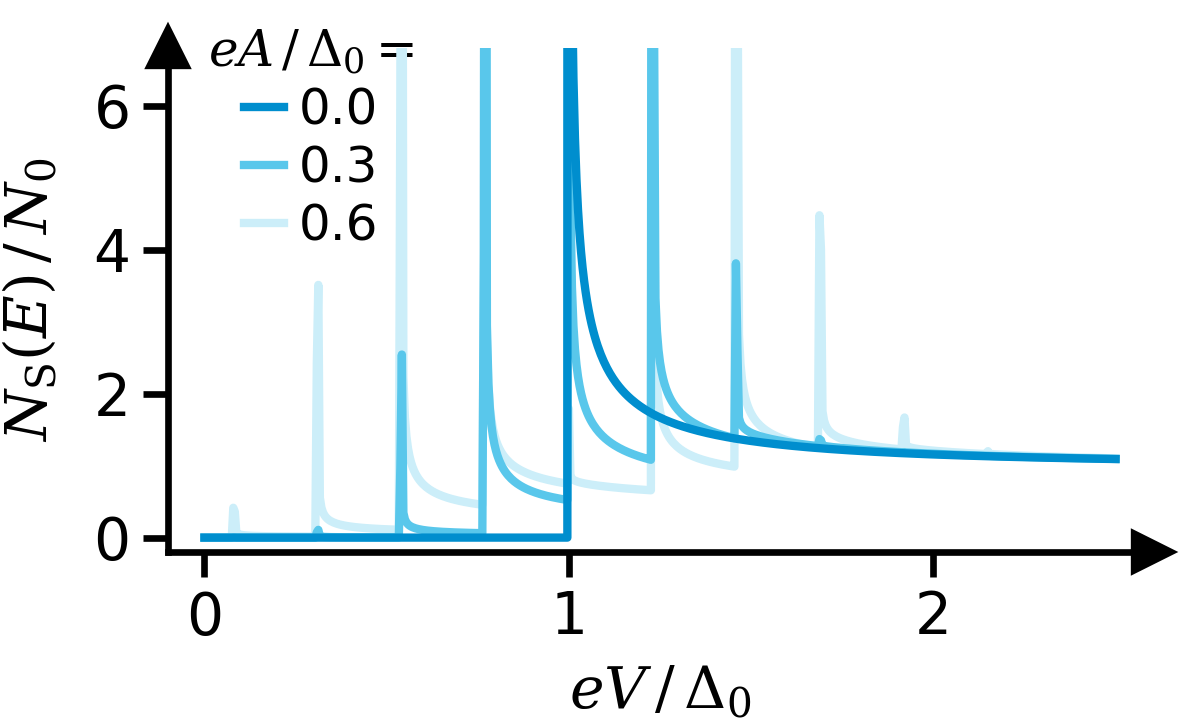

In [19]:
fig, ax = get_figure(figsize=(2.0, 1.2), subfigure=True)

for i, A in enumerate(A_mV):
    # NS
    ax.plot(
        V_mV / Delta_meV,
        N_S[i, :],
        color=seeblau[i * 2],
        zorder=10 - i,
        label=f"{A/Delta_meV:1.1f}",
    )

ax.set_xlim(-0.1, 2.6)
ax.set_xticks([0, 1, 2])
ax.set_ylim(-0.2, 6.8)
ax.set_yticks([0, 2, 4, 6])

ax.legend(
    title="$eA\\,/\\,\\Delta_0 = $",
    handlelength=0.8,
    loc="upper left",
    frameon=False,
    fontsize=6,
    title_fontsize=6,
    ncols=1,
    columnspacing=0.1,
    borderpad=0.1,  # reduces padding inside the legend box
    labelspacing=0.2,  # reduces vertical spacing between items
    handletextpad=0.3,  # reduces spacing between line and label
    bbox_to_anchor=(0.01, 1.1),
)

xlabel = "$eV\\,/\\,\\Delta_0$"
ylabel = "$N_\\mathrm{S}(E)\\,/\\,N_0$"
title = None

theory_layout(fig, ax, title, xlabel, ylabel)

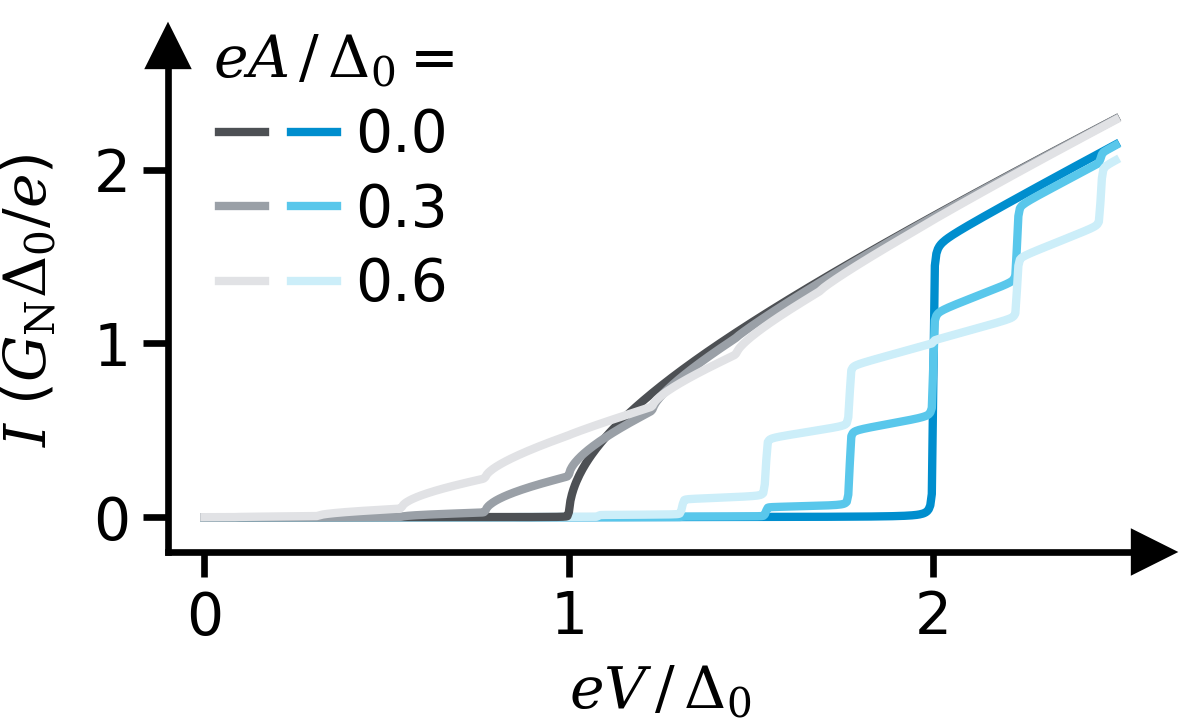

In [20]:
fig, ax = get_figure(figsize=(2.0, 1.2), subfigure=True)

for i, A in enumerate(A_mV):
    # NS
    ax.plot(
        V_mV / Delta_meV,
        I_NS[i, :],
        color=seegrau[2 * i],
        zorder=i + 10,
        label="$\\,$",
    )

for i, A in enumerate(A_mV):
    # SS
    ax.plot(
        V_mV / Delta_meV,
        I_SS[i, :],
        color=seeblau[2 * i],
        zorder=i,
        label=f"{A/Delta_meV:1.1f}",
    )

ax.set_xlim(-0.1, 2.6)
ax.set_ylim(-0.2, 2.7)
ax.set_yticks([0, 1, 2])
ax.set_xticks([0, 1, 2])

ax.legend(
    title="$eA\\,/\\,\\Delta_0 = $",
    handlelength=0.8,
    loc="upper left",
    frameon=False,
    fontsize=7,
    title_fontsize=7,
    ncols=2,
    columnspacing=0.1,
    borderpad=0.1,  # reduces padding inside the legend box
    labelspacing=0.3,  # reduces vertical spacing between items
    handletextpad=0.3,  # reduces spacing between line and label
    bbox_to_anchor=(0.01, 1.1),
)

xlabel = "$eV\\,/\\,\\Delta_0$"
ylabel = "$I$ ($G_\\mathrm{N}\\Delta_0 /e$)"
title = "pat-iv"

theory_layout(fig, ax, title, xlabel, ylabel)

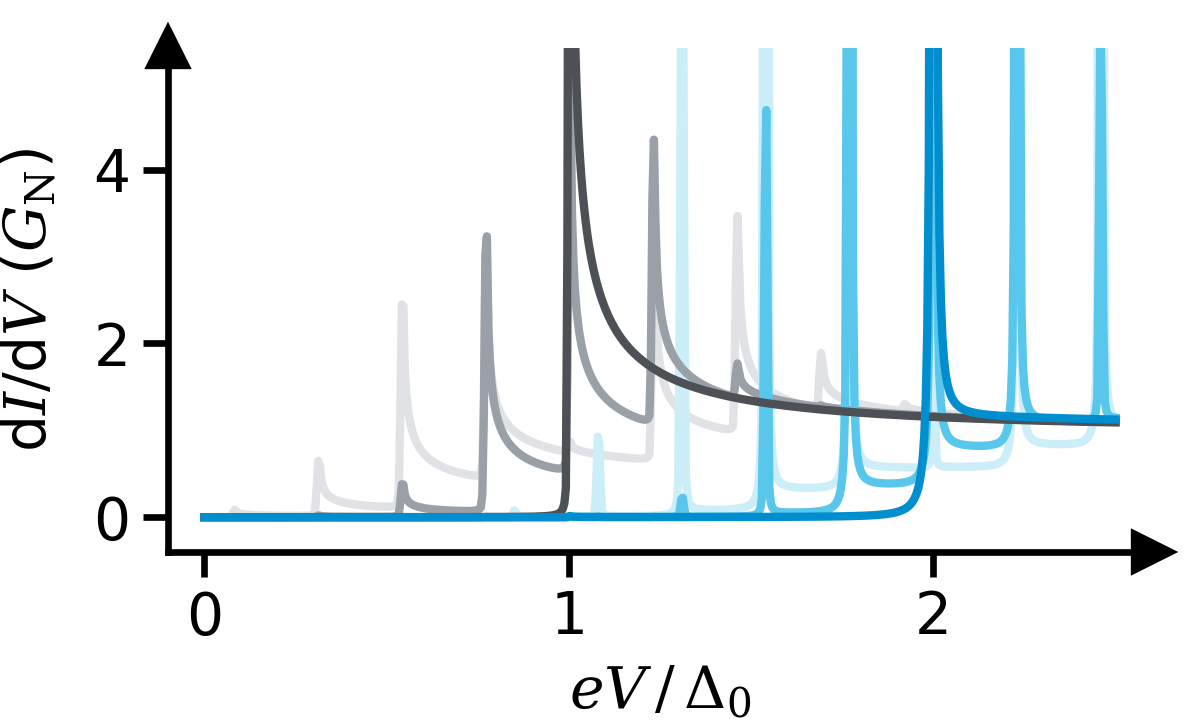

In [21]:
fig, ax = get_figure(figsize=(2.0, 1.2), subfigure=True)

for i, A in enumerate(A_mV):
    ax.plot(
        V_mV / Delta_meV,
        dIdV_NS[i, :],
        color=seegrau[2 * i],
        zorder=10 - i,
    )
    ax.plot(
        V_mV / Delta_meV,
        dIdV_SS[i, :],
        color=seeblau[2 * i],
        zorder=10 - i,
    )

ax.set_xlim(-0.1, 2.6)
ax.set_xticks([0, 1, 2])
ax.set_ylim(-0.4, 5.4)
ax.set_yticks([0, 2, 4])

xlabel = "$eV\\,/\\,\\Delta_0$"
ylabel = "d$I/$d$V$ ($G_\\mathrm{N}$)"
title = "pat-didv"

theory_layout(fig, ax, title, xlabel, ylabel)